# Защита персональных данных клиентов

<h1>Содержание<span class='tocSkip'></span></h1>

* [1 Загрузка данных](#my_section_1) <a id='content_1'></a>
  * [1.1 Загрузка данных](#my_section_2) <a id='content_2'></a>
  * [1.2 Ознакомление](#my_section_3) <a id='content_3'></a>
    * [1.2.1 Проверка на дубликаты](#my_section_4) <a id='content_4'></a>
    * [1.2.2 Изучение выбросов](#my_section_5) <a id='content_5'></a>
    * [1.2.3 Заключение](#my_section_6) <a id='content_6'></a>
  * [1.3 Предобработка](#my_section_7) <a id='content_7'></a>
  * [1.4 Заключение](#my_section_8) <a id='content_8'></a>
* [2 Умножение матриц](#my_section_9) <a id='content_9'></a>
* [3 Алгоритм преобразования](#my_section_10) <a id='content_10'></a>
* [4 Проверка алгоритма](#my_section_11) <a id='content_11'></a>
* [5 Вывод](#my_section_12) <a id='content_12'></a>


# Описание проекта

**Задача:**
- Нужно защитить данные клиентов. Разработь метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обосновать корректность его работы.
- При преобразовании данных качество моделей машинного обучения ухудшиться не должно.

**План работы:**
1. Загрузка и изучение данных.
2. Изучение вопроса и обоснование решения. 
3. Рассмотрение алгоритма преобразования данных.
4. Создание алгоритма.

**Описание данных:**

Набор данных находится в файле data.csv.
- Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.
- Целевой признак: количество страховых выплат клиенту за последние 5 лет.

**Форматирование текста:**
- *Курсивом — небольшие выводы*;
- Обычным — дейсвия.

<a id='my_section_1'></a>
## [Загрузка данных](#content_1)

<a id='my_section_2'></a>
### [Загрузка данных](#content_2)

Проведём загрузку необходимых библиотек и модулей

In [1]:
from random import randint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

Проведём загрузку файла

In [2]:
def download(name):
    path1 = '/datasets/'
    path2 = 'https://..'
    try:
        data = pd.read_csv(name)
    except FileNotFoundError:
        try: 
            data = pd.read_csv(path1 + name)
        except FileNotFoundError:
            data = pd.read_csv(path2 + name)
    except Exception as ex:
        print("Some error:", ex)
    return data    

In [3]:
data = download('data.csv')

<a id='my_section_3'></a>
### [Ознакомление](#content_3)

**head**

Изучим данные

In [4]:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


*Наименования стобцов начинаются в верхнем регитсре и некоторые разделены пробелами. Стоит провести преобразование.*

**Переименование столбцов**

Страхования компания «Хоть потоп» русскоязычная, изменение колонок будет соответствовать.

In [5]:
data.columns

Index(['Пол', 'Возраст', 'Зарплата', 'Члены семьи', 'Страховые выплаты'], dtype='object')

In [6]:
data = data.rename(columns={'Пол':'пол', 'Возраст':'возраст', 'Зарплата':'зарплата',
                            'Члены семьи':'члены_семьи', 'Страховые выплаты':'страховые_выплаты'})

**info**

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   пол                5000 non-null   int64  
 1   возраст            5000 non-null   float64
 2   зарплата           5000 non-null   float64
 3   члены_семьи        5000 non-null   int64  
 4   страховые_выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


*Пропуски в данных не обнаружены. Целевой признак — категориальный, значит решаем задачу классификации. Типы у столбцов указаны в соответствии с находящимся данными, однако не понятно, почему возрасть имеет тип float64. Изучим содержание столбца.*

In [8]:
data['возраст'].unique()

array([41., 46., 29., 21., 28., 43., 39., 25., 36., 32., 38., 23., 40.,
       34., 26., 42., 27., 33., 47., 30., 19., 31., 22., 20., 24., 18.,
       37., 48., 45., 44., 52., 49., 35., 56., 65., 55., 57., 54., 50.,
       53., 51., 58., 59., 60., 61., 62.])

*Тип данных можно изменить на int64, это займёт меньше памяти.*

<a id='my_section_4'></a>
#### [Проверка на дубликаты](#content_4)

Определим функцию для проверки и удаления дубликатов. Проводить поиск будем по всем стобцам, так как признаков мало и велика вероятность совпадения, кроме того, нет уникальных идентификаторов.

In [9]:
def is_duplucates(data, drop=False):
    print(f'Количество дубликатов обнаружено: {data.duplicated().sum()}')
    if drop == True:
        print(f'Строк/столбцов до удаления дубликатов {data.shape}')
        data = data.drop_duplicates()
        print(f'Строк/столбцов после удаления дубликатов {data.shape}')
        return data

In [10]:
is_duplucates(data)

Количество дубликатов обнаружено: 153


<a id='my_section_5'></a>
#### [Изучение выбросов](#content_5)

В рамках задачи данный этап не нужен, так как необходимо защитить данные, чтобы при преобразовании качество модели не ухудшилось.

In [11]:
data.describe()

,пол,возраст,зарплата,члены_семьи,страховые_выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Средние показатели признаков:
- пол: распределение примерно поровну (от 0 до 1);
- возраст: равен 30 годам (от 18 до 65);
- з.п.: 40000 (от 5300 до 79000);
- кол-во членов семьи: 1 (от 1 до 6);
- страховые выплаты: 0.148 (от 0 до 5).

Определим функцию для построения графиков и определения границ усов. Изучать выбросы будем у трёх столбцов(в силу типа представленной информации и отношению их к количественным признакам):
- возраст;
- зарплата;
- члены_семьи.

In [12]:
def box_moustache(data):
    moustache = {}
    col = {'возраст':'лет', 'зарплата':'у.е.', 'члены_семьи':'человек(a)'}
    fig, ax = plt.subplots(1, 3, figsize=(13,6))
    fig.suptitle('Ящики с усами', fontsize=14, fontweight='bold')
    fig.subplots_adjust(top=.8)

    count = 0
    for key, val in col.items():
        b = ax[count].boxplot(data[key])
        # Выделение крайних усов боксплота
        moustache[key] = [item.get_ydata()[1] for item in b['whiskers']]
        ax[count].grid()
        ax[count].set_title(key)
        ax[count].set_ylabel(val)
        count += 1

    fig.tight_layout()


    return moustache    


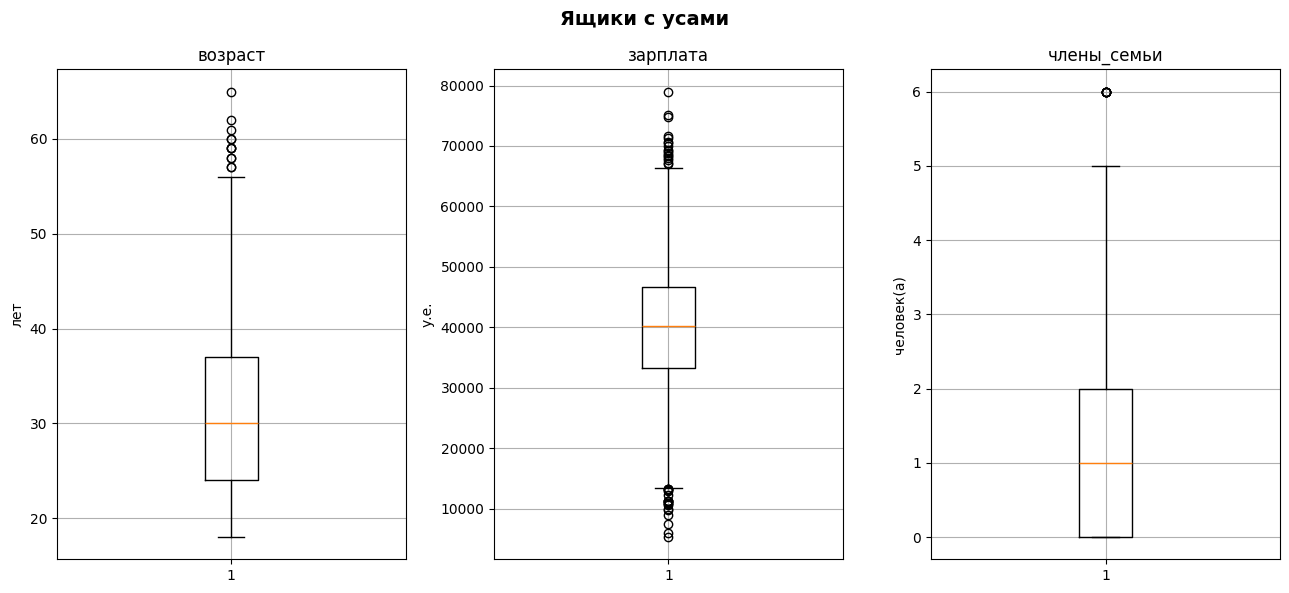

In [13]:
moustache_data = box_moustache(data)

Изучим численные границы

In [14]:
moustache_data

{'возраст': [18.0, 56.0],
 'зарплата': [13400.0, 66300.0],
 'члены_семьи': [0.0, 5.0]}

Определим функцию для ограничения выбранных столбцов по усам

In [15]:
def limit_moustache(data, drop=False):
    data_s = data.shape[0]
    for key, val in moustache_data.items():
        data = data.loc[(data[key] >= val[0]) & (data[key] <= val[1])]
    res = data_s - data.shape[0]
    if drop == False:
        print(f'Обнаружено выбросов: {res}')
    else:
        print(f'Выбросов удалено: {res}')
        return data


In [16]:
limit_moustache(data)

Обнаружено выбросов: 56


<a id='my_section_6'></a>
#### [Заключение](#content_6)

В данных обнаружено:
- столбец `возраст` имеет тип данных float64, а должен int64;
- 153 дубликата при поиске по всем столбцам;
- 56 выбросов.

**Вывод:**
Необходимо провести предобработку данных и избавиться от помех.

<a id='my_section_7'></a>
### [Предобработка](#content_7)

**Изменение типа данных**

In [17]:
data['возраст'] = data['возраст'].astype('int64')

**Избавление от дубликатов**

In [18]:
data = is_duplucates(data, drop=True)

Количество дубликатов обнаружено: 153
Строк/столбцов до удаления дубликатов (5000, 5)
Строк/столбцов после удаления дубликатов (4847, 5)


**Обработка выбросов**

In [19]:
data = limit_moustache(data, drop=True)

Выбросов удалено: 56


<a id='my_section_8'></a>
### [Заключение](#content_8)

Проведено подключение библиотек и модулей, загрузка и ознакомление с данными. Были выявлены помехи, мешающие или усложнающие дальнейшую работу и анализ данных:
- имена столбцов находились в непринятом формате;
- столбец `возраст` имел тип столбца `float64`;
- обнаружено 153 дубликата, если искать по всем столбцам;
- в столбцах: `возраст`, `зарплата`, `члены_семьи` были обнаружено 56 выбросов.

В процессе предобработки было сделано:
- имена столбцов переведены в нижний и 'змеиный' регистр;
- изменён тип столбца `возраст` на `int64`;
- набор данных избавлен от дубликатов;
- столбцы с количественным набором данных избавлены от выбросов.



<a id='my_section_9'></a>
## [Умножение матриц](#content_9)

**Вопрос:** </br>
Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? </br>

**Варианты ответов:**
- a. Изменится. Приведите примеры матриц.
- b. Не изменится.

**Ответ:**
b. Не изменится

**Обоснование:**

Используемые свойства:
$$
(AB)^T=B^T A^T
$$
$$
(AB)^{-1} = B^{-1} A^{-1}
$$
$$
A A^{-1} = A^{-1} A = E
$$
$$
AE = EA = A
$$
\
Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Доказательство:
$$
a = Xw = XEw = XPP^{-1}w = (XP)P^{-1}w = (XP)w'
$$
\
Требуется доказать, что предсказания не изменятся, имеем  $a =  Xw$,   $a' = X'w'$
\
\
$$
    w = (X^T X)^{-1} X^T y
$$
\
$$
w' = ((XP)^T XP)^{-1} (XP)^T y
$$
$$
w' = (P^T (X^T X) P)^{-1} (XP)^T y
$$
$$
w' = (P^T (X^T X) P)^{-1} P^T X^T y
$$

$$
w' = (P)^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$
$$
w' = (P)^{-1} (X^T X)^{-1} E X^T y
$$
$$
w' = (P)^{-1} w
$$


**Заключение:** предсказания не изменятся, согласно итогу проведённого преобразования и доказательства.

**Вывод:**
Качество линейной регресии не изменится при умножении матрицы признаков на обратимую матрицу. Значит, что это можно использовать для шифрования персональной информации.

<a id='my_section_10'></a>
## [Алгоритм преобразования](#content_10)

В этом пункте предложим алгоритм преобразования данных, рассчитанный в прошлом пукте. В целом для задачи кодирования данных подойдут и другие операции с матрицей: умножение и деление на число, вектор, формула будет такая же. Подобные операции справделивы и для обратимых матриц.

**Алгоритм**

Был рассмотрен в пункте 2, где происходило умнажение признаков на обратимую матрицу.

**Обоснование**

Также приведено в главе 2.

<a id='my_section_11'></a>
## [Проверка алгоритма](#content_11)

В этой главе необходимо запрограммировать алгоритм, рассмотренный в главе 2, применив матричные операции. Проверим, что качество линейной регрессии из sklearn не отличается до и после преобразования. Применим метрику R2.

Определим функцию для разделения на выборки и масштабирования

In [20]:
def signs_scal(data):
    features = data.drop(['страховые_выплаты'],axis=1)
    target = data['страховые_выплаты']
    numeric = ['возраст', 'зарплата', 'члены_семьи']
    
    scaler = StandardScaler()
    scaler.fit(features[numeric])

    pd.options.mode.chained_assignment = None
    features.loc[:, numeric] = scaler.transform(features.loc[:, numeric])
    return features, target

Опеределим функцию создания обратимой матрицы и умножения ее на признаки

In [21]:
def data_maker_p(data):
    count = 0
    while True:
        new_matrix = np.random.normal(randint(1, 10), 1000, size=(data.shape[1],data.shape[1]))
        det = np.linalg.det(new_matrix)
        if det != 0:
            break
        elif det == 0:
            count += 1
            if count == 10:
                print('Вероятно есть ошибка в формуле, детерменант равен 0')
                break
    
    new_data = np.dot(data, new_matrix)
    features_p = pd.DataFrame(new_data, columns = data.columns)
    return features_p  

Определим функцию для проверки качества линейной регрессии из sklearn с использованием метрики r2

In [22]:
def Linear_r2_score(features, target):
    model = LinearRegression()
    model.fit(features, target)
    predictions = model.predict(features)
    res = r2_score(target, predictions)
    print(f'Результат вычисления: {res}'
          f'\nОкругление результата: {res :.5}')
    
    return res

Проведём разбиение на признаки и масштабирование

In [23]:
features, target = signs_scal(data) 

Умножим признаки на обратимую матрицу

In [24]:
features_p = data_maker_p(features)

**До преобразования**

Рассчёт качества линейной регресии до преобразования

In [25]:
res_before = Linear_r2_score(features, target)

Результат вычисления: 0.4229314556027187
Округление результата: 0.42293


**После преобразования**

Рассчёт качества линейной регресии после преобразования

In [26]:
res_after = Linear_r2_score(features_p, target)

Результат вычисления: 0.4229314556027187
Округление результата: 0.42293


<a id='my_section_12'></a>
## [Вывод](#content_12)

1. Проведена загрузка и ознакомление с данными, обнаружено:
    - столбец `возраст` имеет тип данных float64, а должен int64;
    - 153 дубликата при поиске по всем столбцам;
    - 56 выбросов.
    
    
2. Проведена предобработка данных, где были исправлены искажения.


3. Проанализирована информации и выбран один из возможных алгоритмов для защиты данных клиентов. Алгоритм основан на шифровании данных путём преобразования исходной информации, умножением признаков на обратимую матрицу во время обучения модели.


4. Проведена проверка алгоритма с использованием метрики r2, где вычеслено значение до преобразования и после, соответственно, значения соответствуют друг друг вплоть до 14 знака:
    - до: 0.4229314556027187 (0.42293)
    - после: 0.42293145560271883 (0.42293)
    
Полученные результаты позволяют заключить, что подобранный алгоритм подходит для защиты данных клиентов.    